# Project Analysis: Film Industry Trends (Pre vs Post COVID)

This notebook consolidates the analysis of genre trends, franchise dynamics, and budget efficiency.

In [8]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import sys
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuration
INPUT_FILE = 'data/raw_dataset_arda.csv'
PRE_COVID_YEARS = [2016, 2017, 2018, 2019]
POST_COVID_YEARS = [2021, 2022, 2023, 2024]
N_BOOTSTRAP = 10000 # Full bootstrap validation


## 1. Centralized Data Loading

In [9]:
def load_and_clean_data(filepath):
    print(f'Loading data from {filepath}...')
    df = pd.read_csv(filepath)
    
    # Parse complex columns stringified by CSV
    def safe_parse(val):
        if isinstance(val, str) and val.strip():
            try:
                return ast.literal_eval(val)
            except:
                return val
        return val
        
    df['genres'] = df['genres'].apply(safe_parse)
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(safe_parse)
    
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce').fillna(0)
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce').fillna(0)
    df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce').fillna(0)
    
    # Identify Franchise
    df['is_franchise'] = df['belongs_to_collection'].apply(lambda x: 1 if pd.notnull(x) else 0)
    
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['year'] = df['release_date'].dt.year
    
    # Filter valid movies
    df = df[(df['vote_count'] >= 10) & (df['revenue'] > 0)].copy()
    
    def get_period(year):
        if year in PRE_COVID_YEARS: return 'Pre-COVID'
        if year in POST_COVID_YEARS: return 'Post-COVID'
        return None
        
    df['period'] = df['year'].apply(get_period)
    # Keep all years for plotting, but analysis will filter by period
    return df

df = load_and_clean_data(INPUT_FILE)
print(f'Total Movies: {len(df)}')
print(f'Franchise Movies: {len(df[df["is_franchise"]==1])}')


Loading data from data/raw_dataset_arda.csv...
Total Movies: 5152
Franchise Movies: 1136


## 2. Core Metrics Functions (Z-Score, Elasticity, Gini)

In [10]:

def gini(array):
    array = np.array(array)
    array = array.flatten()
    if np.amin(array) < 0: return -1
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    if n == 0 or np.sum(array) == 0: return 0
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

def compute_metrics(dataframe, genres):
    # Calculate Volume, Revenue, Budget metrics per period
    period_stats = {}
    for period in ["Pre-COVID", "Post-COVID"]:
        sub = dataframe[dataframe["period"] == period]
        total_rev = sub["revenue"].sum()
        total_budget = sub["budget"].sum()
        total_count = len(sub)
        
        g_rows = []
        for _, row in sub.iterrows():
            if isinstance(row["genres"], list):
                for g in row["genres"]:
                    g_name = g["name"] if isinstance(g, dict) and "name" in g else g if isinstance(g, str) else None
                    if g_name and g_name in genres:
                        g_rows.append({
                            "genre": g_name, 
                            "revenue": row.get("revenue", 0),
                            "budget": row.get("budget", 0),
                            "is_franchise": row.get("is_franchise", 0)
                        })
        g_df = pd.DataFrame(g_rows)
        
        if not g_df.empty:
            vol_counts = g_df["genre"].value_counts()
            budget_sums = g_df.groupby("genre")["budget"].sum()
            rev_sums = g_df.groupby("genre")["revenue"].sum()
            fran_rev_sums = g_df[g_df["is_franchise"] == 1].groupby("genre")["revenue"].sum()
            rev_arrays = g_df.groupby("genre")["revenue"].apply(list)
            budg_arrays = g_df.groupby("genre")["budget"].apply(list)
        else:
            vol_counts = pd.Series()
            budget_sums = pd.Series()
            rev_sums = pd.Series()
            fran_rev_sums = pd.Series()
            rev_arrays = pd.Series()
            budg_arrays = pd.Series()
            
        stats = {}
        for g in genres:
            count = vol_counts.get(g, 0)
            budg = budget_sums.get(g, 0)
            rev = rev_sums.get(g, 0)
            
            vol_share = count / total_count if total_count > 0 else 0
            budg_share = budg / total_budget if total_budget > 0 else 0
            rev_share = rev / total_rev if total_rev > 0 else 0
            
            fran_rev = fran_rev_sums.get(g, 0)
            fran_rev_share = fran_rev / rev if rev > 0 else 0
            
            g_gini = 0
            if g in rev_arrays.index and len(rev_arrays[g]) > 1:
                g_gini = gini(rev_arrays[g])
            
            g_gini_budget = 0
            if g in budg_arrays.index and len(budg_arrays[g]) > 1:
                g_gini_budget = gini(budg_arrays[g])
                
            stats[g] = {
                "count": count, "vol_share": vol_share, 
                "rev_share": rev_share, "budg_share": budg_share,
                "fran_rev_share": fran_rev_share,
                "gini": g_gini, "gini_budget": g_gini_budget
            }
        period_stats[period] = stats, total_count
        
    return period_stats

def calculate_shifts(period_stats, genres):
    pre_stats, n1 = period_stats["Pre-COVID"]
    post_stats, n2 = period_stats["Post-COVID"]
    
    results = {}
    for g in genres:
        s1 = pre_stats[g]
        s2 = post_stats[g]
        
        # Volume Shift
        d_vol = (s2["vol_share"] - s1["vol_share"]) / s1["vol_share"] if s1["vol_share"] > 0 else 0
        diff_prop = s2["vol_share"] - s1["vol_share"] # Actual difference for Z-score numerator
        
        # Revenue Shift (for Elasticity)
        d_rev = (s2["rev_share"] - s1["rev_share"]) / s1["rev_share"] if s1["rev_share"] > 0 else 0
        diff_rev_share = s2["rev_share"] - s1["rev_share"]
        
        # Budget Shift
        d_budg = (s2["budg_share"] - s1["budg_share"]) / s1["budg_share"] if s1["budg_share"] > 0 else 0
        diff_budg_share = s2["budg_share"] - s1["budg_share"]
        
        # Elasticities
        elast_price = d_rev / d_vol if d_vol != 0 else 0
        elast_effic = d_rev / d_budg if d_budg != 0 else 0
        
        # Gini Change
        d_gini = s2["gini"] - s1["gini"]
        d_gini_budget = s2["gini_budget"] - s1["gini_budget"]
        
        # Franchise Rev Saturation Shift
        diff_fran_rev_share = s2["fran_rev_share"] - s1["fran_rev_share"]
        
        results[g] = {
            "diff_prop": diff_prop,
            "d_rev": d_rev,
            "diff_rev_share": diff_rev_share,
            "d_budg": d_budg,
            "diff_budg_share": diff_budg_share,
            "elasticity": elast_price,
            "elasticity_efficiency": elast_effic,
            "d_gini": d_gini,
            "d_gini_budget": d_gini_budget,
            "diff_fran_rev_share": diff_fran_rev_share,
            # For Z-score calc later
            "p1": s1["vol_share"], "p2": s2["vol_share"],
            "x1": s1["count"], "x2": s2["count"]
        }
    return results, n1, n2


## 3. Analysis Execution (Bootstrap)

We perform bootstrap validation for both **General** (All Movies) and **Franchise-Only** datasets.

In [11]:
def run_analysis(dataframe, label='General'):
    # Filter for Analysis Periods
    dataframe = dataframe.dropna(subset=['period']).copy()
    print(f'Running Analysis for: {label} (Movies: {len(dataframe)})...')
    
    # Extract Genres
    all_genres = set()
    for row in dataframe['genres']:
        if isinstance(row, list):
            for g in row:
                if isinstance(g, dict):
                    all_genres.add(g['name'])
    genres = sorted(list(all_genres))
    
    # Observed Metrics
    obs_period_stats = compute_metrics(dataframe, genres)
    obs_results, n1, n2 = calculate_shifts(obs_period_stats, genres)
    
    print(f'Running {N_BOOTSTRAP} bootstrap iterations...')
    bootstrap_vals = {g: {'diff_prop': [], 'elasticity': [], 'd_gini': [], 'diff_budg': [], 'effic_elast': [], 'd_gini_budg': [], 'diff_rev': [], 'diff_fran_rev': []} for g in genres}
    
    pre_df = dataframe[dataframe['period'] == 'Pre-COVID']
    post_df = dataframe[dataframe['period'] == 'Post-COVID']
    
    for i in range(N_BOOTSTRAP):
        res_pre = pre_df.sample(frac=1, replace=True)
        res_post = post_df.sample(frac=1, replace=True)
        res_df = pd.concat([res_pre, res_post])
        
        iter_stats = compute_metrics(res_df, genres)
        iter_results, _, _ = calculate_shifts(iter_stats, genres)
        
        for g in genres:
            r = iter_results[g]
            bootstrap_vals[g]['diff_prop'].append(r['diff_prop'])
            bootstrap_vals[g]['elasticity'].append(r['elasticity'])
            bootstrap_vals[g]['d_gini'].append(r['d_gini'])
            bootstrap_vals[g]['diff_budg'].append(r['diff_budg_share'])
            bootstrap_vals[g]['effic_elast'].append(r['elasticity_efficiency'])
            bootstrap_vals[g]['d_gini_budg'].append(r['d_gini_budget'])
            bootstrap_vals[g]['diff_rev'].append(r['diff_rev_share'])
            bootstrap_vals[g]['diff_fran_rev'].append(r['diff_fran_rev_share'])
            
    # Compile Results
    final_table = []
    for g in genres:
        obs = obs_results[g]
        
        # Volume Z-Score (Analytical)
        p_pool = (obs['x1'] + obs['x2']) / (n1 + n2)
        se_vol = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
        z_vol = (obs['p2'] - obs['p1']) / se_vol if se_vol > 0 else 0
        p_z_vol = 2 * (1 - stats.norm.cdf(abs(z_vol)))
        
        # Budget Z-Score (Bootstrap SE)
        se_budg = np.std(bootstrap_vals[g]['diff_budg'], ddof=1)
        z_budg = obs['diff_budg_share'] / se_budg if se_budg > 0 else 0
        p_z_budg = 2 * (1 - stats.norm.cdf(abs(z_budg)))
        
        # Revenue Z-Score (Bootstrap SE)
        se_rev = np.std(bootstrap_vals[g]['diff_rev'], ddof=1)
        z_rev = obs['diff_rev_share'] / se_rev if se_rev > 0 else 0
        p_z_rev = 2 * (1 - stats.norm.cdf(abs(z_rev)))
        
        # Franchise Revenue Saturation Z-Score (Bootstrap SE)
        se_fran_rev = np.std(bootstrap_vals[g]['diff_fran_rev'], ddof=1)
        z_fran_rev = obs['diff_fran_rev_share'] / se_fran_rev if se_fran_rev > 0 else 0
        p_z_fran_rev = 2 * (1 - stats.norm.cdf(abs(z_fran_rev)))
        
        # P-values from Bootstrap distributions
        dist_elast = np.array(bootstrap_vals[g]['elasticity'])
        p_elast = 2 * min(np.mean(dist_elast > 0), np.mean(dist_elast < 0))
        
        dist_effic = np.array(bootstrap_vals[g]['effic_elast'])
        p_effic = 2 * min(np.mean(dist_effic > 0), np.mean(dist_effic < 0))
        
        dist_gini = np.array(bootstrap_vals[g]['d_gini'])
        p_gini = 2 * min(np.mean(dist_gini > 0), np.mean(dist_gini < 0))
        
        dist_gini_budg = np.array(bootstrap_vals[g]['d_gini_budg'])
        p_gini_budg = 2 * min(np.mean(dist_gini_budg > 0), np.mean(dist_gini_budg < 0))
        
        final_table.append({
            'Genre': g,
            'Z_Vol': z_vol, 'p_Vol': p_z_vol,
            'Z_Budget': z_budg, 'p_Budget': p_z_budg,
            'Z_Revenue': z_rev, 'p_Revenue': p_z_rev,
            'Z_Franchise_Saturation': z_fran_rev, 'p_Franchise_Saturation': p_z_fran_rev,
            'Elasticity': obs['elasticity'], 'p_Elasticity': p_elast,
            'Efficiency': obs['elasticity_efficiency'], 'p_Efficiency': p_effic,
            'Delta_Gini': obs['d_gini'], 'p_Gini': p_gini,
            'Delta_Budget_Gini': obs['d_gini_budget'], 'p_Budget_Gini': p_gini_budg
        })
        
    return pd.DataFrame(final_table)

# Run General Analysis
res_general = run_analysis(df, 'General')
print('General Analysis Results (Top 5 Volume Shifts):')
display(res_general.sort_values(by='Z_Vol', key=abs, ascending=False).head(5))

# Export General Results
res_general[['Genre', 'Z_Vol', 'p_Vol', 'Z_Revenue', 'p_Revenue', 'Z_Franchise_Saturation', 'p_Franchise_Saturation', 'Elasticity', 'p_Elasticity', 'Delta_Gini', 'p_Gini']] \
    .rename(columns={'Z_Vol':'Z_Score', 'p_Vol':'p_Value', 'Z_Revenue':'Z_Score_Revenue', 'p_Revenue':'p_Value_Revenue', 'Delta_Gini':'Delta_Gini'}) \
    .to_csv('data/genre_metrics_compiled.csv', index=False)

res_general[['Genre', 'Z_Budget', 'p_Budget', 'Efficiency', 'p_Efficiency', 'Delta_Budget_Gini', 'p_Budget_Gini']] \
    .rename(columns={'Z_Budget':'Z_Score_Budget', 'p_Budget':'p_Z', 'Efficiency':'Elasticity_Efficiency', 'Delta_Budget_Gini':'Delta_Budget_Gini', 'p_Budget_Gini':'p_Gini'}) \
    .to_csv('data/genre_budget_metrics.csv', index=False)

# Run Franchise Analysis
df_franchise = df[df['is_franchise'] == 1].copy()
res_franchise = run_analysis(df_franchise, 'Franchise')
print('Franchise Analysis Results (Top 5 Volume Shifts):')
display(res_franchise.sort_values(by='Z_Vol', key=abs, ascending=False).head(5))

# Export Franchise Results
res_franchise[['Genre', 'Z_Vol', 'p_Vol', 'Z_Revenue', 'p_Revenue', 'Z_Franchise_Saturation', 'p_Franchise_Saturation', 'Elasticity', 'p_Elasticity', 'Delta_Gini', 'p_Gini']] \
    .rename(columns={'Z_Vol':'Z_Score', 'p_Vol':'p_Value', 'Z_Revenue':'Z_Score_Revenue', 'p_Revenue':'p_Value_Revenue'}) \
    .to_csv('data/franchise_metrics_compiled.csv', index=False)

res_franchise[['Genre', 'Z_Budget', 'p_Budget', 'Efficiency', 'p_Efficiency', 'Delta_Budget_Gini', 'p_Budget_Gini']] \
    .rename(columns={'Z_Budget':'Z_Score_Budget', 'p_Budget':'p_Z', 'Efficiency':'Elasticity_Efficiency', 'Delta_Budget_Gini':'Delta_Budget_Gini', 'p_Budget_Gini':'p_Gini'}) \
    .to_csv('data/franchise_budget_metrics.csv', index=False)


Running Analysis for: General (Movies: 4248)...
Running 10000 bootstrap iterations...
General Analysis Results (Top 5 Volume Shifts):


,Genre,Z_Vol,p_Vol,Z_Budget,p_Budget,Z_Revenue,p_Revenue,Z_Franchise_Saturation,p_Franchise_Saturation,Elasticity,p_Elasticity,Efficiency,p_Efficiency,Delta_Gini,p_Gini,Delta_Budget_Gini,p_Budget_Gini
10,Horror,3.343338,0.000828,1.334467,0.182051,0.625282,0.531786,0.003737,0.997018,0.507825,0.5198,0.465588,0.3928,0.002844,0.8796,-0.000141,0.9644
11,Music,2.302397,0.021313,1.025978,0.304902,-0.450558,0.652308,-0.547742,0.583869,-0.410257,0.6940,-0.407553,0.9724,-0.037498,0.3090,-0.030892,0.6078
17,War,-2.090401,0.036582,-0.726158,0.467742,-0.031348,0.974992,1.349112,0.177301,0.049275,0.9118,0.062047,0.5546,0.014923,0.8132,0.121301,0.0146
4,Crime,-2.081371,0.037400,0.875243,0.381442,0.968842,0.332624,0.857947,0.390922,-1.654671,0.3520,1.360305,0.3026,-0.030737,0.3358,0.040443,0.1818
1,Adventure,-1.969908,0.048849,-1.611803,0.107005,-1.822417,0.068392,-0.115959,0.907685,1.301580,0.1008,1.329127,0.1060,0.012514,0.6016,0.016733,0.5048


Running Analysis for: Franchise (Movies: 935)...
Running 10000 bootstrap iterations...
Franchise Analysis Results (Top 5 Volume Shifts):


,Genre,Z_Vol,p_Vol,Z_Budget,p_Budget,Z_Revenue,p_Revenue,Z_Franchise_Saturation,p_Franchise_Saturation,Elasticity,p_Elasticity,Efficiency,p_Efficiency,Delta_Gini,p_Gini,Delta_Budget_Gini,p_Budget_Gini
16,Thriller,2.856017,0.004290,0.952707,0.340739,0.470866,0.637736,0.000000,1.000000,0.314722,0.6376,0.457127,0.3742,-0.018286,0.7108,0.038121,0.3908
9,History,1.802130,0.071525,1.218966,0.222857,0.671589,0.501845,0.000000,1.000000,0.659684,0.4856,0.224650,0.4064,0.067169,0.7478,0.023188,0.8684
18,Western,1.640877,0.100823,1.357939,0.174483,1.377124,0.168474,2.970444,0.002974,0.000000,0.0000,0.000000,0.0000,0.024441,0.0000,0.125000,0.0000
15,TV Movie,-1.496796,0.134446,-0.993358,0.320536,-1.401768,0.160985,-4.491506,0.000007,1.000000,0.0000,1.000000,0.0000,-0.335306,0.0000,-0.665134,0.0000
0,Action,1.458237,0.144775,0.481923,0.629860,0.014614,0.988340,0.000000,1.000000,0.013782,0.8698,0.036842,0.4418,-0.002115,0.9092,0.018973,0.5986


## 4. Overall Industry & Franchise Saturation Analysis

In [12]:
def calculate_overall_metrics(dataframe):
    # Metrics: Mean Rev, Mean Budget, Franchise Vol Share, Franchise Rev Share, Franchise Bud Share
    # + Overall Gini Revenue, Overall Gini Budget (Individual Inequality)
    # + Genre Gini (Structural Concentration)
    stats = {}
    for period in ['Pre-COVID', 'Post-COVID']:
        sub = dataframe[dataframe['period'] == period]
        total_n = len(sub)
        if total_n == 0: continue
        
        # Overall Means
        mean_rev = sub['revenue'].mean()
        mean_bud = sub['budget'].mean()
        
        # Overall Gini (Individual Movies)
        rev_list = sub['revenue'].tolist()
        bud_list = sub['budget'].tolist()
        gini_rev = gini(rev_list) if len(rev_list) > 0 else 0
        gini_bud = gini(bud_list) if len(bud_list) > 0 else 0
        
        # Genre Concentration Gini (Structural)
        # Expand genres to count/sum per genre
        exploded = sub.explode('genres')
        filtered_genres = exploded[exploded['genres'].apply(lambda x: isinstance(x, dict))]
        if not filtered_genres.empty:
            filtered_genres['genre_name'] = filtered_genres['genres'].apply(lambda x: x.get('name'))
            g_stats = filtered_genres.groupby('genre_name').agg({
                'revenue': 'sum',
                'budget': 'sum',
                'title': 'count'
            }).rename(columns={'title': 'count'})
            
            gini_genre_vol = gini(g_stats['count'].values) if len(g_stats) > 0 else 0
            gini_genre_rev = gini(g_stats['revenue'].values) if len(g_stats) > 0 else 0
            gini_genre_bud = gini(g_stats['budget'].values) if len(g_stats) > 0 else 0
        else:
            gini_genre_vol, gini_genre_rev, gini_genre_bud = 0, 0, 0
        
        # Franchise Saturation
        fran_sub = sub[sub['is_franchise'] == 1]
        fran_n = len(fran_sub)
        fran_vol_share = fran_n / total_n
        
        total_rev = sub['revenue'].sum()
        fran_rev = fran_sub['revenue'].sum()
        fran_rev_share = fran_rev / total_rev if total_rev > 0 else 0
        
        total_bud = sub['budget'].sum()
        fran_bud = fran_sub['budget'].sum()
        fran_bud_share = fran_bud / total_bud if total_bud > 0 else 0
        
        stats[period] = {
            'Mean_Revenue': mean_rev,
            'Mean_Budget': mean_bud,
            'Overall_Gini_Coefficient': gini_rev,
            'Overall_Bud_Gini': gini_bud,
            'Genre_Vol_Gini': gini_genre_vol,
            'Genre_Rev_Gini': gini_genre_rev,
            'Genre_Bud_Gini': gini_genre_bud,
            'Franchise_Vol_Share': fran_vol_share,
            'Franchise_Rev_Share': fran_rev_share,
            'Franchise_Bud_Share': fran_bud_share,
            'Total_Volume': total_n # For analytical Z-score, not bootstrap
        }
    return stats

print('Running Overall & Franchise Shift Analysis...')
obs_overall = calculate_overall_metrics(df)

# Bootstrap for Overall Metrics (Excluding Total Volume which is fixed in bootstrap)
boot_diffs = {
    'Mean_Revenue': [], 'Mean_Budget': [],
    'Overall_Gini_Coefficient': [], 'Overall_Bud_Gini': [],
    'Genre_Vol_Gini': [], 'Genre_Rev_Gini': [], 'Genre_Bud_Gini': [],
    'Franchise_Vol_Share': [], 'Franchise_Rev_Share': [], 'Franchise_Bud_Share': []
}

pre_df = df[df['period'] == 'Pre-COVID']
post_df = df[df['period'] == 'Post-COVID']

for i in range(N_BOOTSTRAP):
    res_pre = pre_df.sample(frac=1, replace=True)
    res_post = post_df.sample(frac=1, replace=True)
    res_df = pd.concat([res_pre, res_post])
    
    iter_stats = calculate_overall_metrics(res_df)
    for metric in boot_diffs.keys():
        diff = iter_stats['Post-COVID'][metric] - iter_stats['Pre-COVID'][metric]
        boot_diffs[metric].append(diff)

overall_results = []
for metric in boot_diffs.keys():
    obs_diff = obs_overall['Post-COVID'][metric] - obs_overall['Pre-COVID'][metric]
    se = np.std(boot_diffs[metric], ddof=1)
    z_score = obs_diff / se if se > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    overall_results.append({
        'Metric': metric,
        'Pre_Value': obs_overall['Pre-COVID'][metric],
        'Post_Value': obs_overall['Post-COVID'][metric],
        'Delta': obs_diff,
        'Z_Score': z_score,
        'p_Value': p_value
    })

# Analytical Z-Score for Volume Change (Poisson Approximation)
n1 = obs_overall['Pre-COVID']['Total_Volume']
n2 = obs_overall['Post-COVID']['Total_Volume']
delta_n = n2 - n1
se_n = np.sqrt(n1 + n2)
z_n = delta_n / se_n if se_n > 0 else 0
p_n = 2 * (1 - stats.norm.cdf(abs(z_n)))

overall_results.insert(0, { # Add to top
    'Metric': 'Total_Volume',
    'Pre_Value': n1,
    'Post_Value': n2,
    'Delta': delta_n,
    'Z_Score': z_n,
    'p_Value': p_n
})

res_overall_df = pd.DataFrame(overall_results)
print('Overall Industry Shifts:')
display(res_overall_df)
res_overall_df.to_csv('data/overall_industry_metrics.csv', index=False)
print('Saved data/overall_industry_metrics.csv')


Running Overall & Franchise Shift Analysis...
Overall Industry Shifts:


,Metric,Pre_Value,Post_Value,Delta,Z_Score,p_Value
0,Total_Volume,2.331000e+03,1.917000e+03,-4.140000e+02,-6.351965,2.125820e-10
1,Mean_Revenue,5.748896e+07,4.704707e+07,-1.044189e+07,-2.054325,3.994428e-02
2,Mean_Budget,1.607774e+07,1.710853e+07,1.030783e+06,0.801314,4.229500e-01
3,Overall_Gini_Coefficient,8.538032e-01,8.621667e-01,8.363544e-03,1.001076,3.167903e-01
4,Overall_Bud_Gini,8.209255e-01,8.436806e-01,2.275512e-02,2.829741,4.658565e-03
5,Genre_Vol_Gini,4.464761e-01,4.401120e-01,-6.364070e-03,-0.473658,6.357441e-01
6,Genre_Rev_Gini,5.123887e-01,4.870357e-01,-2.535302e-02,-0.971968,3.310664e-01
7,Genre_Bud_Gini,5.135635e-01,4.952211e-01,-1.834243e-02,-0.829148,4.070207e-01
8,Franchise_Vol_Share,2.299442e-01,2.081377e-01,-2.180651e-02,-1.723260,8.484157e-02
9,Franchise_Rev_Share,6.154085e-01,6.088208e-01,-6.587770e-03,-0.146929,8.831879e-01


Saved data/overall_industry_metrics.csv


## 5. Visualizations

### Market Health Trend (Volume vs Revenue Share)

Plotting...


NameError: name 'OUTPUT_FILE' is not defined

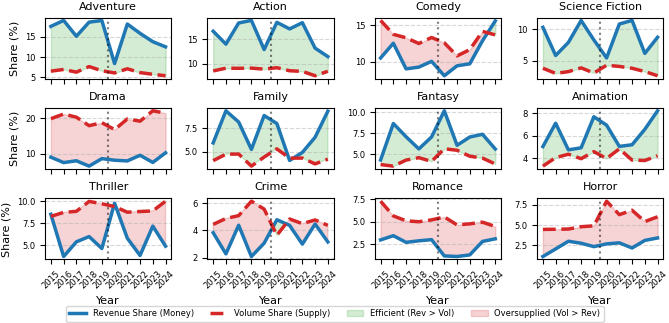

In [13]:
# Reusing loaded 'df' for plotting
from utils.plotting_style import set_style
genre_rows = []

for idx, row in df.iterrows():
    if not isinstance(row["genres"], list):
        continue

    rev = row.get("revenue", 0)
    if rev is None:
        rev = 0

    for g in row["genres"]:
        genre_name = g["name"]
        if genre_name == "TV Movie":
            continue

        genre_rows.append({"year": row["year"], "genre": genre_name, "revenue": rev})

df_flat = pd.DataFrame(genre_rows)


vol_grouped = df_flat.groupby(["year", "genre"]).size().reset_index(name="count")
year_vol_totals = df_flat.groupby("year").size().reset_index(name="total_year_count")
vol_merged = pd.merge(vol_grouped, year_vol_totals, on="year")
vol_merged["volume_share"] = (
    vol_merged["count"] / vol_merged["total_year_count"]
) * 100


rev_grouped = df_flat.groupby(["year", "genre"])["revenue"].sum().reset_index()
year_rev_totals = (
    df_flat.groupby("year")["revenue"]
    .sum()
    .reset_index()
    .rename(columns={"revenue": "total_year_rev"})
)
rev_merged = pd.merge(rev_grouped, year_rev_totals, on="year")
rev_merged["revenue_share"] = (
    rev_merged["revenue"] / rev_merged["total_year_rev"]
) * 100


metrics = pd.merge(
    vol_merged[["year", "genre", "volume_share"]],
    rev_merged[["year", "genre", "revenue_share"]],
    on=["year", "genre"],
    how="outer",
).fillna(0)


total_rev_by_genre = (
    df_flat.groupby("genre")["revenue"].sum().sort_values(ascending=False)
)
top_genres = total_rev_by_genre.head(12).index.tolist()

plot_data = metrics[metrics["genre"].isin(top_genres)].copy()


print("Plotting...")

num_genres = len(top_genres)
cols = 4
rows = (num_genres // cols) + (1 if num_genres % cols > 0 else 0)

# Set Style (adjust col/nrows dynamically)
set_style(column="full", nrows=rows, ncols=cols)

fig, axes = plt.subplots(rows, cols, sharex=True)
axes = axes.flatten()


years = sorted(plot_data["year"].unique())

for i, genre in enumerate(top_genres):
    ax = axes[i]
    g_data = plot_data[plot_data["genre"] == genre].sort_values("year")

    g_data = g_data.set_index("year").reindex(years, fill_value=0).reset_index()

    ax.plot(
        g_data["year"],
        g_data["revenue_share"],
        color="#1f77b4",
        linewidth=2.5,
        label="Revenue Share" if i == 0 else "",
    )
    ax.plot(
        g_data["year"],
        g_data["volume_share"],
        color="#d62728",
        linewidth=2.5,
        linestyle="--",
        label="Volume Share" if i == 0 else "",
    )

    ax.fill_between(
        g_data["year"],
        g_data["revenue_share"],
        g_data["volume_share"],
        where=(g_data["revenue_share"] >= g_data["volume_share"]),
        interpolate=True,
        color="#2ca02c",
        alpha=0.2,
    )

    ax.fill_between(
        g_data["year"],
        g_data["revenue_share"],
        g_data["volume_share"],
        where=(g_data["revenue_share"] < g_data["volume_share"]),
        interpolate=True,
        color="#d62728",
        alpha=0.2,
    )

    ax.axvline(2019.5, color="black", linestyle=":", alpha=0.5)

    ax.set_title(genre)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Year")
        ax.set_xticks(years)
        ax.set_xticklabels([str(y) for y in years], rotation=45)

    if i % cols == 0:
        ax.set_ylabel("Share (%)")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


handles = [
    plt.Line2D([], [], color="#1f77b4", linewidth=2.5, label="Revenue Share (Money)"),
    plt.Line2D(
        [],
        [],
        color="#d62728",
        linewidth=2.5,
        linestyle="--",
        label="Volume Share (Supply)",
    ),
    plt.Rectangle(
        (0, 0), 1, 1, color="#2ca02c", alpha=0.2, label="Efficient (Rev > Vol)"
    ),
    plt.Rectangle(
        (0, 0), 1, 1, color="#d62728", alpha=0.2, label="Oversupplied (Vol > Rev)"
    ),
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.05),
    frameon=True,
)


# plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
print(f"Saved {OUTPUT_FILE}")

### Financial Health Trend (Budget vs Revenue Share)

In [ ]:
genre_rows = []

for idx, row in df.iterrows():
    if not isinstance(row["genres"], list):
        continue

    rev = row.get("revenue", 0)
    if rev is None:
        rev = 0

    budget = row.get("budget", 0)
    if budget is None:
        budget = 0

    for g in row["genres"]:
        genre_name = g["name"]
        if genre_name == "TV Movie":
            continue

        genre_rows.append(
            {"year": row["year"], "genre": genre_name, "revenue": rev, "budget": budget}
        )

df_flat = pd.DataFrame(genre_rows)


budget_grouped = df_flat.groupby(["year", "genre"])["budget"].sum().reset_index()
year_budget_totals = (
    df_flat.groupby("year")["budget"]
    .sum()
    .reset_index()
    .rename(columns={"budget": "total_year_budget"})
)
budget_merged = pd.merge(budget_grouped, year_budget_totals, on="year")
budget_merged["budget_share"] = (
    budget_merged["budget"] / budget_merged["total_year_budget"]
) * 100


rev_grouped = df_flat.groupby(["year", "genre"])["revenue"].sum().reset_index()
year_rev_totals = (
    df_flat.groupby("year")["revenue"]
    .sum()
    .reset_index()
    .rename(columns={"revenue": "total_year_rev"})
)
rev_merged = pd.merge(rev_grouped, year_rev_totals, on="year")
rev_merged["revenue_share"] = (
    rev_merged["revenue"] / rev_merged["total_year_rev"]
) * 100


metrics = pd.merge(
    budget_merged[["year", "genre", "budget_share"]],
    rev_merged[["year", "genre", "revenue_share"]],
    on=["year", "genre"],
    how="outer",
).fillna(0)


total_rev_by_genre = (
    df_flat.groupby("genre")["revenue"].sum().sort_values(ascending=False)
)
top_genres = total_rev_by_genre.head(12).index.tolist()

plot_data = metrics[metrics["genre"].isin(top_genres)].copy()


print("Plotting...")
num_genres = len(top_genres)
cols = 4
rows = (num_genres // cols) + (1 if num_genres % cols > 0 else 0)

# Set Style (adjust col/nrows dynamically)
set_style(column="full", nrows=rows, ncols=cols)

fig, axes = plt.subplots(rows, cols, sharex=True)
axes = axes.flatten()


years = sorted(plot_data["year"].unique())

for i, genre in enumerate(top_genres):
    ax = axes[i]
    g_data = plot_data[plot_data["genre"] == genre].sort_values("year")

    g_data = g_data.set_index("year").reindex(years, fill_value=0).reset_index()

    ax.plot(
        g_data["year"],
        g_data["revenue_share"],
        color="#1f77b4",
        linewidth=2.5,
        label="Revenue Share" if i == 0 else "",
    )
    ax.plot(
        g_data["year"],
        g_data["budget_share"],
        color="#9467bd",
        linewidth=2.5,
        linestyle="--",
        label="Budget Share" if i == 0 else "",
    )

    ax.fill_between(
        g_data["year"],
        g_data["revenue_share"],
        g_data["budget_share"],
        where=(g_data["revenue_share"] >= g_data["budget_share"]),
        interpolate=True,
        color="#2ca02c",
        alpha=0.2,
    )

    ax.fill_between(
        g_data["year"],
        g_data["revenue_share"],
        g_data["budget_share"],
        where=(g_data["revenue_share"] < g_data["budget_share"]),
        interpolate=True,
        color="#d62728",
        alpha=0.2,
    )

    ax.axvline(2019.5, color="black", linestyle=":", alpha=0.5)

    ax.set_title(genre)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Year")
        ax.set_xticks(years)
        ax.set_xticklabels([str(y) for y in years], rotation=45)

    if i % cols == 0:
        ax.set_ylabel("Share (%)")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


handles = [
    plt.Line2D([], [], color="#1f77b4", linewidth=2.5, label="Revenue Share (Return)"),
    plt.Line2D(
        [],
        [],
        color="#9467bd",
        linewidth=2.5,
        linestyle="--",
        label="Budget Share (Investment)",
    ),
    plt.Rectangle(
        (0, 0), 1, 1, color="#2ca02c", alpha=0.2, label="High ROI (Rev > Budget)"
    ),
    plt.Rectangle(
        (0, 0), 1, 1, color="#d62728", alpha=0.2, label="Low ROI (Budget > Rev)"
    ),
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.05),
    frameon=True,
)


# plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
print(f"Saved {OUTPUT_FILE}")

### Revenue Share Reorientation (Slopegraph)

In [ ]:
# Reusing loaded 'df' for plotting
genre_rows = []

for idx, row in df.iterrows():
    if not isinstance(row["genres"], list):
        continue

    for g in row["genres"]:
        genre_name = g.get("name") if isinstance(g, dict) else g
        if genre_name == "TV Movie" or not genre_name:
            continue

        genre_rows.append(
            {
                "period": row["period"],
                "genre": genre_name,
                "revenue": row.get("revenue", 0),
            }
        )

df_flat = pd.DataFrame(genre_rows)

# Calculate Shares per Period
period_grouped = df_flat.groupby(["period", "genre"])["revenue"].sum().reset_index()

# Calculate Period Totals (Industry Totals)
period_totals = (
    df_flat.groupby("period")["revenue"]
    .sum()
    .reset_index()
    .rename(columns={"revenue": "ind_rev"})
)

merged = pd.merge(period_grouped, period_totals, on="period")
merged["rev_share"] = (merged["revenue"] / merged["ind_rev"]) * 100

# Identify Top 12 Genres (by sum of shares or total volume? Use total rev)
top_genres = (
    df_flat.groupby("genre")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(12)
    .index.tolist()
)
plot_data = merged[merged["genre"].isin(top_genres)].copy()

print("Plotting Slopegraphs...")

num_genres = len(top_genres)
cols = 4  # 4 cols
rows = 3  # 3 rows

# Set Style
set_style(column="full", nrows=rows, ncols=cols)

# We want "half the space" of original full page figures.
# tueplots creates figures sized for the column width.
# nrows=3 might be tall. Let's try to make it compact?
# The bundle handles font scaling.

fig, axes = plt.subplots(
    rows, cols, sharex=True, sharey=True
)  # Share Y to show relative scale?
# Ideally, slopegraphs share scale to be comparable.
axes = axes.flatten()

# Prepare Pivoted Data
pivoted = plot_data.pivot(index="genre", columns="period", values="rev_share")
# Cols: [Post-COVID, Pre-COVID] usually sorted alphabetically?
# 'Post-COVID' comes before 'Pre-COVID' alphabetically? No. 'P' 'o' vs 'P' 'r'. 'o' < 'r'.
# So Post-COVID is col 0, Pre-COVID is col 1.
# Let's be explicit
pivoted = pivoted[["Pre-COVID", "Post-COVID"]]

ymin = pivoted.min().min()
ymax = pivoted.max().max()
pad = (ymax - ymin) * 0.1

for i, genre in enumerate(top_genres):
    ax = axes[i]
    if genre not in pivoted.index:
        continue

    start_val = pivoted.loc[genre, "Pre-COVID"]
    end_val = pivoted.loc[genre, "Post-COVID"]

    # Color logic
    color = "#2ca02c" if end_val > start_val else "#d62728"  # Green vs Red

    # Plot Line
    ax.plot([0, 1], [start_val, end_val], color=color, linewidth=2.5, marker="o")

    # Annotate Values
    ax.text(
        -0.1,
        start_val,
        f"{start_val:.1f}%",
        ha="right",
        va="center",
        fontsize=8,
        color="#333333",
    )
    ax.text(
        1.1,
        end_val,
        f"{end_val:.1f}%",
        ha="left",
        va="center",
        fontsize=8,
        color=color,
        fontweight="bold",
    )

    ax.set_title(genre, pad=10, fontsize=10)

    # Minimalist Axes
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Pre", "Post"])

    # Remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.get_yaxis().set_visible(False)  # Hide Y axis ticks, we labeled points directly

    # Grid?
    ax.grid(axis="y", linestyle=":", alpha=0.3)

# Remove empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Caption
fig.text(
    0.5,
    -0.05,
    "Figure 1: The Great Reorientation—Slopegraphs indicate the net change in Revenue Share from the Pre-COVID baseline\n"
    "to the Post-COVID Adjustment period; note the sharp decline in Action/Adventure spectacle compared to the resilience of Family/Horror genres.",
    ha="center",
    fontsize=9,
    style="italic",
)

# plt.tight_layout() # Careful with figure text
plt.subplots_adjust(bottom=0.15)  # Make room for caption

plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
print(f"Saved {OUTPUT_FILE}")

### Genre Proximity (Correlation Matrix)

In [ ]:
# Reusing loaded 'df' for plotting

# Add parent directory to path to import utils

set_style()

OUTPUT_FILE = "plots/genre_correlation_matrix.pdf"
N_BOOTSTRAP = 1000

# exit(1)



# Parse genres stringified by CSV
def safe_parse_genres(val):
    if isinstance(val, str) and val.strip():
        try:
            return ast.literal_eval(val)
        except:
            return []
    return []


df["genres"] = df["genres"].apply(safe_parse_genres)

# Extract genres into dummy variables
# We need to expand the list of dicts to a flat list of genre names first
df_exploded = df.explode("genres")
df_exploded["genre_name"] = df_exploded["genres"].apply(
    lambda x: x["name"] if isinstance(x, dict) else None
)
df_exploded = df_exploded.dropna(subset=["genre_name"])

# Filter out TV Movie as requested in other plots
df_exploded = df_exploded[df_exploded["genre_name"] != "TV Movie"]

# Create a crosstab: Rows=Movies, Cols=Genres
# We need a unique identifier for movies (original index is preserved after explode)
df_exploded["movie_index"] = df_exploded.index

# Pivot to one-hot encoding
genre_matrix = pd.crosstab(df_exploded.index, df_exploded["genre_name"])

# Remove rare genres if any (though tmdb usually has standard set)
# Keep only genres with sufficient volume
valid_genres = genre_matrix.sum().sort_values(ascending=False).index
genre_matrix = genre_matrix[valid_genres]

print(f"Calculating correlation for {len(valid_genres)} genres...")
print(f"Running {N_BOOTSTRAP} bootstrap iterations for robust estimation...")

# Observed Matrix (for reference/shape)
obs_corr = genre_matrix.corr(method="pearson")

# Bootstrap
bootstrap_matrices = []
n_samples = len(genre_matrix)

# Pre-compute indices to speed up loop (optional, but pandas overhead dominates)
# We will just sample efficiently inside loop
for i in range(N_BOOTSTRAP):
    if i % 100 == 0:
        print(f"Iteration {i}/{N_BOOTSTRAP}...")

    # Resample movies (rows) with replacement
    # sample() is slower than numpy indexing
    sample_indices = np.random.choice(genre_matrix.index, size=n_samples, replace=True)

    # Using .loc with numpy array of indices handles duplicate indices correctly (resampling)
    sample_df = genre_matrix.loc[sample_indices]

    # Calculate Correlation
    corr = sample_df.corr(method="pearson")
    bootstrap_matrices.append(corr.values)

# Calculate Mean Correlation
bootstrap_array = np.array(bootstrap_matrices)
mean_corr_values = np.mean(bootstrap_array, axis=0)

# Reconstruct DataFrame with correct labels
mean_corr_matrix = pd.DataFrame(
    mean_corr_values, index=obs_corr.index, columns=obs_corr.columns
)

# Plotting
print("Plotting Mean Bootstrap Correlation...")
plt.figure(figsize=(10, 8))  # Standardize size

# Mask upper triangle
mask = np.triu(np.ones_like(mean_corr_matrix, dtype=bool))

sns.heatmap(
    mean_corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",  # Diverging colormap
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={
        "shrink": 0.7,
        "label": f"Mean Pearson Correlation ({N_BOOTSTRAP} Bootstraps)",
    },
    annot_kws={"size": 6},  # Smaller font for numbers
)

plt.title(f"Genre Co-occurrence: Mean Bootstrap Correlation (n={N_BOOTSTRAP})")
plt.xlabel("")  # Genres self-explanatory
plt.ylabel("")

plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
print(f"Saved {OUTPUT_FILE}")

### Franchise Saturation Trend (Volume vs Revenue %)

In [ ]:
# Reusing loaded 'df' for plotting
genre_rows = []

for idx, row in df.iterrows():
    if not isinstance(row["genres"], list):
        continue

    rev = row.get("revenue", 0)
    if rev is None:
        rev = 0

    is_fran = row.get("is_franchise", 0)

    for g in row["genres"]:
        genre_name = g.get("name") if isinstance(g, dict) else g
        if genre_name == "TV Movie" or not genre_name:
            continue

        genre_rows.append(
            {
                "year": row["year"],
                "genre": genre_name,
                "revenue": rev,
                "is_franchise": is_fran,
            }
        )

df_flat = pd.DataFrame(genre_rows)

# Group by Year and Genre to calculate Franchise Shares
# Franchise Volume Share = (Franchise Count / Total Count) * 100
# Franchise Revenue Share = (Franchise Revenue / Total Revenue) * 100

grouped = (
    df_flat.groupby(["year", "genre"])
    .agg(
        total_count=("is_franchise", "count"),
        franchise_count=("is_franchise", "sum"),
        total_revenue=("revenue", "sum"),
        franchise_revenue=(
            "revenue",
            lambda x: x[df_flat.loc[x.index, "is_franchise"] == 1].sum(),
        ),
    )
    .reset_index()
)

grouped["franchise_vol_share"] = (
    grouped["franchise_count"] / grouped["total_count"]
) * 100
# Handle zero revenue
grouped["franchise_rev_share"] = 0.0
mask = grouped["total_revenue"] > 0
grouped.loc[mask, "franchise_rev_share"] = (
    grouped.loc[mask, "franchise_revenue"] / grouped.loc[mask, "total_revenue"]
) * 100

# Identify Top Genres by Total Revenue (to match other plots)
total_rev_by_genre = (
    df_flat.groupby("genre")["revenue"].sum().sort_values(ascending=False)
)
top_genres = total_rev_by_genre.head(12).index.tolist()

plot_data = grouped[grouped["genre"].isin(top_genres)].copy()

print("Plotting Franchise Saturation...")

num_genres = len(top_genres)
cols = 4
rows = (num_genres // cols) + (1 if num_genres % cols > 0 else 0)

# Set Style (adjust col/nrows dynamically)
set_style(column="full", nrows=rows, ncols=cols)

fig, axes = plt.subplots(rows, cols, sharex=True)
axes = axes.flatten()

years = sorted(plot_data["year"].unique())

for i, genre in enumerate(top_genres):
    ax = axes[i]
    g_data = plot_data[plot_data["genre"] == genre].sort_values("year")

    # Reindex to ensure all years present (fill with 0 if missing)
    g_data = g_data.set_index("year").reindex(years, fill_value=0).reset_index()

    # Plot Franchise Revenue %
    ax.plot(
        g_data["year"],
        g_data["franchise_rev_share"],
        color="#9467bd",  # Purple
        linewidth=2.5,
        label="Franchise Rev %" if i == 0 else "",
    )
    # Plot Franchise Volume %
    ax.plot(
        g_data["year"],
        g_data["franchise_vol_share"],
        color="#e377c2",  # Pink/Magenta
        linewidth=2.5,
        linestyle="--",
        label="Franchise Vol %" if i == 0 else "",
    )

    # Fill areas
    # Purple fill if Rev share > Vol share (High Yield Franchise)
    ax.fill_between(
        g_data["year"],
        g_data["franchise_rev_share"],
        g_data["franchise_vol_share"],
        where=(g_data["franchise_rev_share"] >= g_data["franchise_vol_share"]),
        interpolate=True,
        color="#9467bd",
        alpha=0.2,
    )

    # Pink fill if Vol share > Rev share (Low Yield Franchise)
    ax.fill_between(
        g_data["year"],
        g_data["franchise_rev_share"],
        g_data["franchise_vol_share"],
        where=(g_data["franchise_rev_share"] < g_data["franchise_vol_share"]),
        interpolate=True,
        color="#e377c2",
        alpha=0.2,
    )

    ax.axvline(2019.5, color="black", linestyle=":", alpha=0.5)

    ax.set_title(genre)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Year")
        ax.set_xticks(years)
        ax.set_xticklabels([str(y) for y in years], rotation=45)

    if i % cols == 0:
        ax.set_ylabel("Franchise %")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Legend
handles = [
    plt.Line2D([], [], color="#9467bd", linewidth=2.5, label="Franchise Revenue %"),
    plt.Line2D(
        [],
        [],
        color="#e377c2",
        linewidth=2.5,
        linestyle="--",
        label="Franchise Volume %",
    ),
    plt.Rectangle(
        (0, 0), 1, 1, color="#9467bd", alpha=0.2, label="High Yield (Rev > Vol)"
    ),
    plt.Rectangle(
        (0, 0), 1, 1, color="#e377c2", alpha=0.2, label="Low Yield (Vol > Rev)"
    ),
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.05),
    frameon=True,
)

plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
print(f"Saved {OUTPUT_FILE}")

### Integrated Financial Health (Total Share & Franchise Contribution)

In [ ]:
# Reusing loaded 'df' for plotting
genre_rows = []

for idx, row in df.iterrows():
    if not isinstance(row["genres"], list):
        continue

    rev = row.get("revenue", 0)
    budg = row.get("budget", 0)
    is_fran = row.get("is_franchise", 0)

    for g in row["genres"]:
        genre_name = g.get("name") if isinstance(g, dict) else g
        if genre_name == "TV Movie" or not genre_name:
            continue

        genre_rows.append(
            {
                "year": row["year"],
                "genre": genre_name,
                "revenue": rev,
                "franchise_revenue": rev if is_fran else 0,
                "budget": budg,
                "is_franchise": is_fran,
            }
        )

df_flat = pd.DataFrame(genre_rows)

# Calculate Global Totals per year
year_totals = (
    df_flat.groupby("year")
    .agg(total_year_rev=("revenue", "sum"), total_year_budg=("budget", "sum"))
    .reset_index()
)

# Group by Year and Genre
grouped = (
    df_flat.groupby(["year", "genre"])
    .agg(
        genre_total_rev=("revenue", "sum"),
        genre_total_budg=("budget", "sum"),
        genre_franchise_rev=("franchise_revenue", "sum"),
    )
    .reset_index()
)

grouped = pd.merge(grouped, year_totals, on="year")

# Calculate Global Shares
grouped["total_rev_share"] = (
    grouped["genre_total_rev"] / grouped["total_year_rev"]
) * 100
grouped["total_budg_share"] = (
    grouped["genre_total_budg"] / grouped["total_year_budg"]
) * 100
# Contribution (Global Franchise Share)
grouped["franchise_rev_share_global"] = (
    grouped["genre_franchise_rev"] / grouped["total_year_rev"]
) * 100

# Identify Top Genres by Total Revenue
total_rev_by_genre = (
    df_flat.groupby("genre")["revenue"].sum().sort_values(ascending=False)
)
top_genres = total_rev_by_genre.head(12).index.tolist()

plot_data = grouped[grouped["genre"].isin(top_genres)].copy()

print("Plotting Integrated Financial & Franchise Trend (Auto-scaled)...")

num_genres = len(top_genres)
cols = 4
rows = (num_genres // cols) + (1 if num_genres % cols > 0 else 0)

# Set Style
set_style(column="full", nrows=rows, ncols=cols)

# Colors
COLOR_REV_TOTAL = "#003366"  # Dark Navy
COLOR_REV_FRAN = "#6699CC"  # Lighter Blue
COLOR_BUDG = "#333333"  # Dark Grey

fig, axes = plt.subplots(rows, cols, sharex=True)
axes = axes.flatten()

years = sorted(plot_data["year"].unique())

for i, genre in enumerate(top_genres):
    ax = axes[i]
    g_data = plot_data[plot_data["genre"] == genre].sort_values("year")
    g_data = g_data.set_index("year").reindex(years, fill_value=0).reset_index()

    # 1. Total Revenue Share (Line)
    ax.plot(
        g_data["year"],
        g_data["total_rev_share"],
        color=COLOR_REV_TOTAL,
        linewidth=2.5,
        label="Total Rev Share" if i == 0 else "",
        zorder=4,
    )

    # 2. Franchise Revenue Share (Line) - to mimic scale behavior
    ax.plot(
        g_data["year"],
        g_data["franchise_rev_share_global"],
        color=COLOR_REV_FRAN,
        linewidth=2.0,
        linestyle="-",  # Solid thin line
        label="Franchise Rev (Contribution)" if i == 0 else "",
        zorder=3,
    )

    # 3. Total Budget Share (Dashed Line)
    ax.plot(
        g_data["year"],
        g_data["total_budg_share"],
        color=COLOR_BUDG,
        linewidth=2.0,
        linestyle="--",
        label="Budget Share" if i == 0 else "",
        zorder=5,
    )

    # 4. Fill between Total Rev and Franchise Rev (Non-Franchise Gap)
    # This keeps the "Integrated" look without forcing 0
    ax.fill_between(
        g_data["year"],
        g_data["franchise_rev_share_global"],
        g_data["total_rev_share"],
        color=COLOR_REV_TOTAL,
        alpha=0.1,  # Very light fill to show "Non-Franchise" mass
        label="Non-Franchise Rev" if i == 0 else "",
        zorder=1,
    )

    # 5. Fill between 0 and Franchise Rev? -> No, that forces 0.
    # We leave the bottom open to allow zooming.

    ax.axvline(2019.5, color="black", linestyle=":", alpha=0.3, linewidth=1)

    ax.set_title(genre, pad=10)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    # REMOVING ylim(bottom=0) to allow auto-scaling like in financial_health_trend

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Year")
        ax.set_xticks(years)
        ax.set_xticklabels([str(y) for y in years], rotation=45)

    if i % cols == 0:
        ax.set_ylabel("Share (%)")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Clean Legend
handles = [
    plt.Line2D([], [], color=COLOR_REV_TOTAL, linewidth=2.5, label="Total Rev Share"),
    plt.Line2D(
        [], [], color=COLOR_BUDG, linewidth=2.0, linestyle="--", label="Budget Share"
    ),
    plt.Line2D(
        [], [], color=COLOR_REV_FRAN, linewidth=2.0, label="Franchise Rev (Contrib)"
    ),
    plt.Rectangle(
        (0, 0), 1, 1, color=COLOR_REV_TOTAL, alpha=0.1, label="Non-Franchise Gap"
    ),
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.05),
    frameon=False,
)

plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
print(f"Saved {OUTPUT_FILE}")